<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/Brain_MRI/Main_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proejct Description

In this project i wanted to create a hybrid model.
I will call a hybrid model a model whcih is created by combining 2 models, one pretrained and one who is not trained

Our dataset consists of 4 different types of brain tumours:
- glioma
- meningioma
- notumor
- pituitary

The scope of this project is an educational one showing how we can use pretrained models to suit everyday problems by simply adding extra layers to the model

## Setting up the dependencies

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import requests
import zipfile
from pathlib import Path
import os
from torchvision import datasets

In [2]:
# Device agnostic code for using the available device
device= "cuda" if torch.cuda.is_available() else "cpu"

## Importing the dataset from cloud

In [3]:
import requests
import zipfile
from pathlib import Path

data_path=Path("data")
image_path=data_path/"mri_dataset"

if image_path.is_dir():
  print(f"Directory exists")
else:
  print(f"Creating one")
  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/"mri_dataset.zip","wb") as f:
    request=requests.get("https://drive.google.com/uc?id=18EjZCBP-BSHm-KvJaNFFstcVNzfpBX6c&confirm=t&uuid=8c91b8a4-f047-4792-9f8f-d1498b8a00f2&at=AB6BwCB840jlSMqB2AZNLKsH-wBE:1695384666961")
    print("Downloading")
    f.write(request.content)

  with zipfile.ZipFile(data_path/"mri_dataset.zip","r") as zip_ref:
    print("Unzipping")
    zip_ref.extractall(image_path)

os.remove(data_path / "mri_dataset.zip")

Creating one
Downloading
Unzipping


In [4]:
# Creating the directories for our train and test images

train_dir=image_path/"Training"
test_dir=image_path/"Testing"

## Visualize one random image

Label:glioma


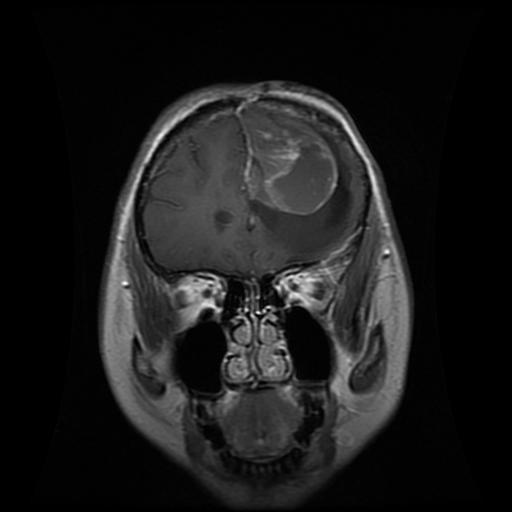

In [5]:
import random
from PIL import Image

image_path_list=list(image_path.glob("*/*/*.jpg"))
random_image_path=random.choice(image_path_list)

image_class=random_image_path.parent.stem
image=Image.open(random_image_path)
print(f"Label: {image_class}")
image

## Creating the dataloaders

In [6]:
# Creating a simple transform for our problem.

#  For the train transform i wanted to invert the colours because the mri scan is in black and white,
# so that our model can detect better the anomalies in the scan
train_transform= transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomInvert(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

#  For the test transform we haven't done any data augmentation , we want our model to guess
# on pure data, like a scan from a medical institute
test_transform= transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
# Setting up the train data and test data
train_data=datasets.ImageFolder(train_dir,
                                transform=train_transform,
                                target_transform=None)
test_data=datasets.ImageFolder(test_dir,
                               transform=test_transform)

# Creating the dataloaders, we are using a batch size of 32
train_dataloader=DataLoader(train_data,
                            batch_size=32,
                            shuffle=True)
test_dataloader=DataLoader(test_data,
                           batch_size=32,
                           shuffle=True)

# Creating the class names
class_names=train_data.classes

## Importing our pre-trained model and training it

In [ ]:
# Importing our model and freezing the params

from torchvision.models.resnet import ResNet50_Weights
model_pretrained=torchvision.models.resnet50(pretrained=True,
                                             weights=ResNet50_Weights)

for param in model_pretrained.parameters():
    param.requires_grad = False



###Here we are creating a modified version of our pretrained model because we want our model to adapt for our specific task. In order to do this we have added a small architecture(tiny-vgg)

In [ ]:
# Creating our custom model where we will combine the pretrained model with a simple one

class CustomModel(nn.Module):
  def __init__ (self,original_model):
    super().__init__()
    self.model=nn.Sequential(*list(original_model.children())[:-2])

    # Below we are creating another model

    self.layer_1=nn.Sequential(
        nn.Conv2d(2048,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )
    self.layer_2=nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(512*8*8,128),
        nn.ReLU(),
        nn.Linear(128,4)
    )

  def forward(self,x):
    # Combining the model into one

    x=self.model(x)
    x=self.layer_1(x)
    x=self.layer_2(x)
    x=self.classifier(x)

    return x


# Crafting our custom model and sending it to the available device
custom_resnet=CustomModel(model_pretrained)
custom_resnet.to(device)

In [16]:
from timeit import default_timer as timer

optimizer = torch.optim.SGD(params=custom_resnet.parameters(),lr=0.001)
loss_fn=nn.CrossEntropyLoss()

epochs= 10

torch.cuda.manual_seed(36)
torch.manual_seed(36)

train_loss_list=[]
test_loss_list=[]
train_accuracy_list=[]
test_accuracy_list=[]

start_time=timer()

for epoch in range(epochs):
  train_loss=0
  train_accuracy=0

  for batch, (X,y) in enumerate(train_dataloader):
    X,y=X.to(device),y.to(device)

    #Forward pass
    y_pred=custom_resnet(X)

    #Calculate the loss and add it
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    #optimizer zero grad/backpropagation/optimzier step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Calculate the accuracy
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_accuracy+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(train_dataloader)
  train_accuracy=train_accuracy/len(train_dataloader)

  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  test_loss=0
  test_accuracy=0

  custom_resnet.eval()
  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y=X.to(device),y.to(device)

      #Forward pass
      test_pred=custom_resnet(X)

      #Calculate the loss
      loss=loss_fn(test_pred,y)
      test_loss+=loss.item()

      #Calculate the accuracy
      test_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
      test_accuracy+=(test_pred_class==y).sum().item()/len(test_pred)

  test_loss=test_loss/len(test_dataloader)
  test_accuracy=test_accuracy/len(test_dataloader)

  test_loss_list.append(test_loss)
  test_accuracy_list.append(test_accuracy)

  print(f"Epoch:{epoch+1}")
  print(f"Train Loss :{train_loss}| Train Accuracy: {train_accuracy}")
  print(f"Test Loss :{test_loss}| Test Accuracy: {test_accuracy}")

end_time=timer()

print(f"Total training time : {end_time-start_time:.3f}")



Epoch:1
Train Loss :0.5483073567211961| Train Accuracy: 0.8037709497206704
Test Loss :0.5825213150280278| Test Accuracy: 0.7764309598741148
Epoch:2
Train Loss :0.43319512695573564| Train Accuracy: 0.8453212290502793
Test Loss :0.3797851982640057| Test Accuracy: 0.8406028717545239
Epoch:3
Train Loss :0.24755462296515204| Train Accuracy: 0.9079958100558659
Test Loss :0.3384287186512133| Test Accuracy: 0.8787126278520849
Epoch:4
Train Loss :0.19791213248195594| Train Accuracy: 0.9285963687150838
Test Loss :0.3012490908547146| Test Accuracy: 0.8741148701809598
Epoch:5
Train Loss :0.15507241886879145| Train Accuracy: 0.9429120111731844
Test Loss :0.23103538337277202| Test Accuracy: 0.912986821400472
Epoch:6
Train Loss :0.12265032404960867| Train Accuracy: 0.9574022346368715
Test Loss :0.17144370142643045| Test Accuracy: 0.944359756097561
Epoch:7
Train Loss :0.10789998942288939| Train Accuracy: 0.9643854748603352
Test Loss :0.22938152657049457| Test Accuracy: 0.919182730133753
Epoch:8
Train 

## Plotting our results

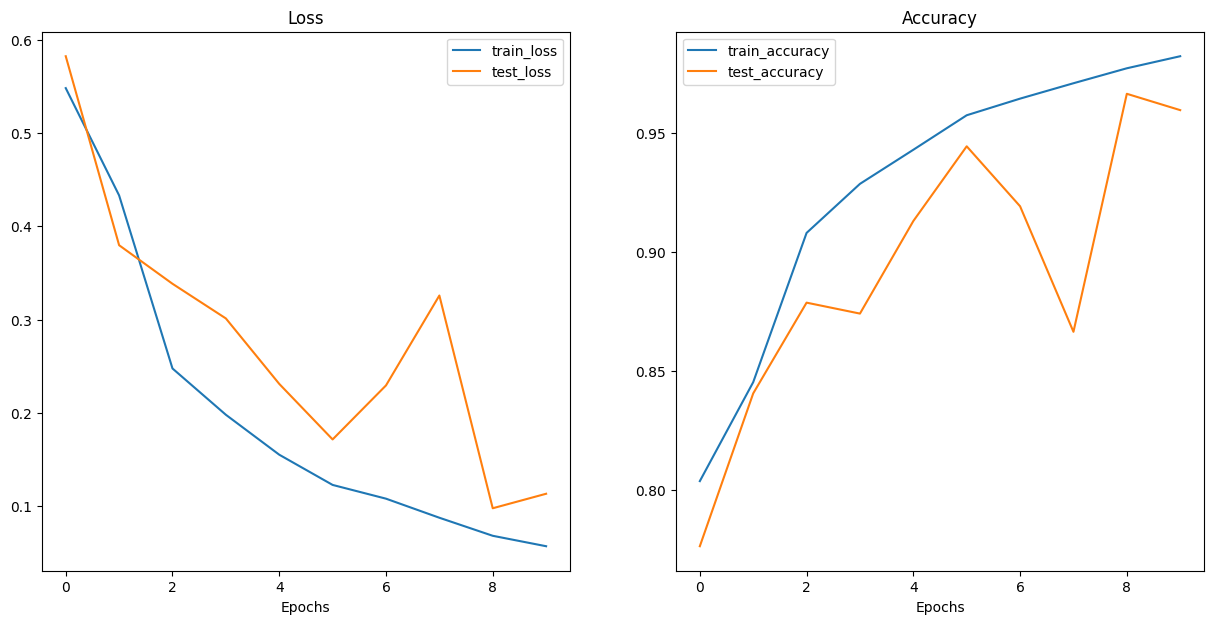

In [17]:
loss = train_loss_list
test_loss = test_loss_list
accuracy = train_accuracy_list
test_accuracy = test_accuracy_list

epochs = range(len(train_loss_list))

plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, test_loss, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='train_accuracy')
plt.plot(epochs, test_accuracy, label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [36]:
# The values we got so far after 10 epochs of training

print(f"Loss values:\n.....................................")
print(f"Average train loss : {sum(train_loss_list)/len(train_loss_list)}")
print(f"Average test loss : {sum(test_loss_list)/len(test_loss_list)}")
print(f"\nLast train loss :{train_loss_list[len(train_loss_list)-1]}")
print(f"Last test loss :{test_loss_list[len(test_loss_list)-1]}")
print(f"\nAccuracy values:\n.....................................")
print(f"Average train accuracy : {sum(train_accuracy_list)/len(train_accuracy_list)*100:.2f}%")
print(f"Average test accuracy: {sum(test_accuracy_list)/len(test_accuracy_list)*100:.2f}%")
print(f"\nLast train accuracy :{train_accuracy_list[len(train_accuracy_list)-1]*100:.2f}%")
print(f"Last test accuracy :{test_accuracy_list[len(test_accuracy_list)-1]*100:.2f}%")

Loss values:
.....................................
Average train loss : 0.2025012323398705
Average test loss : 0.27704590818413144

Last train loss :0.05689284428641949
Last test loss :0.11317535830525363

Accuracy values:
.....................................
Average train accuracy : 92.81%
Average test accuracy: 89.39%

Last train accuracy :98.22%
Last test accuracy :95.96%
